# Problem statement

https://scholar.google.co.in/scholar_url?url=https://dspace.mit.edu/bitstream/handle/1721.1/43141/247085315-MIT.pdf%3Fsequence%3D2&hl=en&sa=X&ei=3mqcZtL-Op2A6rQPutDjsQU&scisig=AFWwaeaRgp7e--N60Rqptm_OmoMw&oi=scholarr

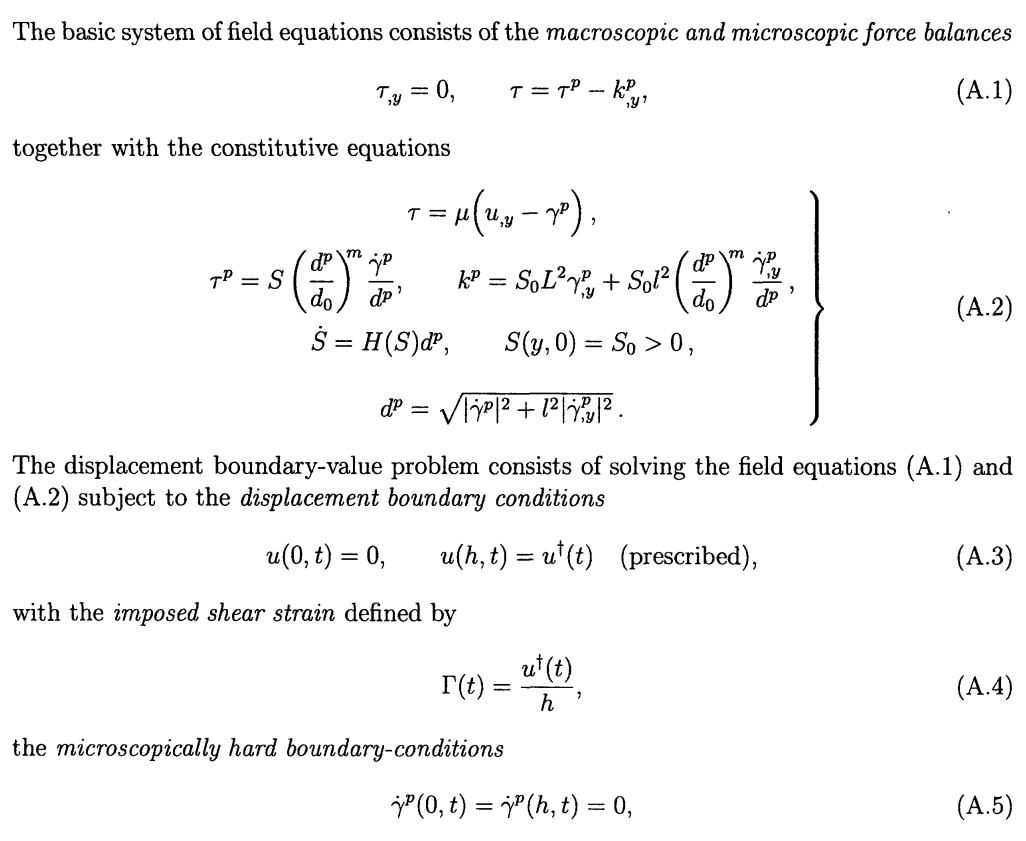

In [1]:
from IPython.display import Image
Image(filename='SGP_1D.png', width = 500)

# imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
import FINDER_core

Using cuda device for FINDER


In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


# Boundary and collocation points

In [4]:
xmin = 0
xmax = 10
tmin = 0
tmax = 0.5
umax = 1.0

In [5]:
length = xmax - xmin
total_time = tmax - tmin

In [6]:
S0 = 100
μ = 100e3
d0 = 0.1
m = 0.02

In [7]:
l_en = length
L = length
T = total_time
Γ = S0 / μ
U = Γ * L

x0 = xmin / L
x1 = xmax / L
t0 = tmin / T
t1 = tmax / T

In [8]:
nx = 100
nt = 100
ts = torch.linspace(t0, t1, nt)
ts = ts[1:]
xs = torch.linspace(x0, x1, nx)
xs = xs[1:-1]
tgrid, xgrid = torch.meshgrid(ts, xs)
X_train = torch.cat((tgrid.flatten().unsqueeze(1), xgrid.flatten().unsqueeze(1)), dim=1)

/home/uttam/miniforge3/envs/torch/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
# x_ax = torch.rand(100)
# t_ax = torch.rand(100)
# X_train = torch.cartesian_prod(x_ax, t_ax)

In [10]:
X_train.shape

torch.Size([9702, 2])

# model class

In [11]:
class Model(nn.Module):
    def __init__(self, X_c):
        super(Model, self).__init__()
        self.t = X_c[:,0].clone().detach().reshape(-1,1).requires_grad_(True).to(device)
        self.x = X_c[:,1].clone().detach().reshape(-1,1).requires_grad_(True).to(device)
        self.X_f = torch.cat([self.x, self.t], dim = 1)
        self.X_f.requires_grad_(True)
        
        self.create_net()
        self.loss = nn.MSELoss()
        self.ls = 0
        self.start = torch.nn.utils.parameters_to_vector(self.parameters()).detach().clone().to(device)
        self.grads = torch.zeros_like(self.start)
        
    def subnet(self):
        return nn.Sequential(
            nn.Linear(2, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 100), nn.Tanh(),
            nn.Linear(100, 1))
    
    def create_net(self):
        self.u =  self.subnet()
        self.γp = self.subnet()
        
    def net_f (self):
        self.u_m = self.X_f[:,0:1] * (1 - self.X_f[:,0:1]) * self.X_f[:,1:2] * self.u(self.X_f) + self.X_f[:,1:2] * self.X_f[:,0:1] * (umax/U)
        self.γp_m = self.X_f[:,0:1] * (1 - self.X_f[:,0:1]) * self.X_f[:,1:2] * self.γp(self.X_f)

        du_dx = torch.autograd.grad(self.u_m, self.X_f, grad_outputs=torch.ones_like(self.u_m), create_graph=True)[0][:,0:1]
        d2u_dx2 = torch.autograd.grad(du_dx, self.X_f, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:,0:1]
        dγp_dx = torch.autograd.grad(self.γp_m, self.X_f, grad_outputs=torch.ones_like(self.γp_m), create_graph=True)[0][:,0:1]
        γpdot = torch.autograd.grad(self.γp_m, self.X_f, grad_outputs=torch.ones_like(self.γp_m), create_graph=True)[0][:,1:2]
        d2γp_dx2 = torch.autograd.grad(dγp_dx, self.X_f, grad_outputs=torch.ones_like(dγp_dx), create_graph=True)[0][:,0:1]
        dp = torch.abs(γpdot)

        macro_loss = self.loss((d2u_dx2 - dγp_dx), torch.zeros_like(d2u_dx2))
        micro_loss = self.loss((du_dx - self.γp_m - ((dp * Γ/T)/d0)**m * torch.sign(γpdot) + (S0/μ) * l_en**2 * d2γp_dx2/L**2), torch.zeros_like(du_dx))
        colloc_loss = macro_loss + micro_loss
        return colloc_loss
    
    def loss_grad(self, param, inputs = None, labels = None, no_grad = False):
        # setting the network parameters
        torch.nn.utils.vector_to_parameters(param, self.parameters())

        # zeroing the gradients
        self.zero_grad()

        if no_grad == False:
            self.ls = self.net_f()
            self.ls.backward()
            self.grads[:] = torch.nn.utils.parameters_to_vector([token.grad for token in self.parameters()])
            return self.ls.detach().item(), self.grads
        else:
            loss_f = self.net_f()
            with torch.no_grad():
                self.ls = loss_f
                return self.ls.detach().item()

    def closure(self):
        self.zero_grad()
        self.ls = self.net_f()
        self.ls.backward()
        return self.ls

# model

In [12]:
model = Model(X_train).to(device)

In [13]:
start = torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone()

In [14]:
start.shape

torch.Size([182602])

# train with LBFGS

In [34]:
# Create the model and optimizer

torch.nn.utils.vector_to_parameters(start.clone(), model.parameters())
optimizer_LBFGS = torch.optim.LBFGS(model.parameters(), lr=1, line_search_fn="strong_wolfe")
every = 1
# Train the model

fx_LBFGS = []
tic = time.time()
model.train()
for epoch in range(5000):
    
    loss = model.net_f()#model_adam.loss_grad(torch.nn.utils.parameters_to_vector(model_adam.parameters()), inputs=None)[0]
    model.zero_grad()
    loss.backward()
    loss = optimizer_LBFGS.step(closure = model.closure)
    fx_LBFGS.append(loss.item())
    
    if (epoch) % every == 0 or epoch == 999:
        print('Epoch [%d] loss: %.8f' % (epoch, loss))
    if loss < 1e-1:
        break

toc = time.time()
print("Finished training in: ", toc - tic, " seconds")

Epoch [0] loss: 3470.65698242
Epoch [1] loss: 2779.28857422
Epoch [2] loss: 1615.79553223
Epoch [3] loss: 870.65002441
Epoch [4] loss: 324.03823853
Epoch [5] loss: 74.96778870
Epoch [6] loss: 38.60720062
Epoch [7] loss: 24.26044464
Epoch [8] loss: 17.94053268
Epoch [9] loss: 15.84135342
Epoch [10] loss: 8.63580513
Epoch [11] loss: 6.62050152
Epoch [12] loss: 5.53104782
Epoch [13] loss: 4.07436466
Epoch [14] loss: 1.81342649
Epoch [15] loss: 1.51543093
Epoch [16] loss: 1.15885520
Epoch [17] loss: 0.99021089
Epoch [18] loss: 0.90232080
Epoch [19] loss: 0.84038031
Epoch [20] loss: 0.80858415
Epoch [21] loss: 0.75477690
Epoch [22] loss: 0.62270421
Epoch [23] loss: 0.60242021
Epoch [24] loss: 0.58950824
Epoch [25] loss: 0.56089497
Epoch [26] loss: 0.53129679
Epoch [27] loss: 0.52055883
Epoch [28] loss: 0.50833333
Epoch [29] loss: 0.50353956
Epoch [30] loss: 0.47118455
Epoch [31] loss: 0.45048320
Epoch [32] loss: 0.43658388
Epoch [33] loss: 0.42528951
Epoch [34] loss: 0.42320859
Epoch [35] l

In [35]:
runtime_lbfgs = round(toc - tic)

# train with Adam

In [18]:
# Create the model and optimizer

torch.nn.utils.vector_to_parameters(start.clone(), model.parameters())
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer_Adam, start_factor=1.0, end_factor=0.01, total_iters=50000)
every = 1000
# Train the model

fx_adam = []
tic = time.time()
model.train()
for epoch in range(50000):
    
    loss = model.net_f()
    model.zero_grad()
    loss.backward()
    optimizer_Adam.step()
    scheduler.step()
    fx_adam.append(loss.item())
    
    if (epoch) % every == 0 or epoch == 49999:
        print('Epoch [%d] loss: %.8f' % (epoch, loss))
    if loss < 1e-1:
        break

toc = time.time()
runtime_adam = round(toc - tic)
print("Finished training in: ", toc - tic, " seconds")

Epoch [0] loss: 3470.65698242
Epoch [1000] loss: 2235.02856445
Epoch [2000] loss: 1497.28295898
Epoch [3000] loss: 951.46600342
Epoch [4000] loss: 562.44305420
Epoch [5000] loss: 341.21655273
Epoch [6000] loss: 130.39915466
Epoch [7000] loss: 45.08738708
Epoch [8000] loss: 10.16709518
Epoch [9000] loss: 2.16983128
Epoch [10000] loss: 1.66839349
Epoch [11000] loss: 0.51178789
Epoch [12000] loss: 0.31944218
Epoch [13000] loss: 0.30674839
Epoch [14000] loss: 0.30985186
Epoch [15000] loss: 0.31272686
Epoch [16000] loss: 0.32722080
Epoch [17000] loss: 0.28869081
Epoch [18000] loss: 0.27143341
Epoch [19000] loss: 0.54088324
Epoch [20000] loss: 0.37032855
Epoch [21000] loss: 0.48165694
Epoch [22000] loss: 0.35007700
Epoch [23000] loss: 0.27206963
Epoch [24000] loss: 0.26268566
Epoch [25000] loss: 1.22721934
Epoch [26000] loss: 0.25896272
Epoch [27000] loss: 0.25846213
Epoch [28000] loss: 0.27174610
Epoch [29000] loss: 0.25733620
Epoch [30000] loss: 0.26087615
Epoch [31000] loss: 0.25752932
Ep

# train with FINDER

In [19]:
torch.nn.utils.vector_to_parameters(start.clone(), model.parameters())

In [20]:
FINDER = FINDER_core.FINDER(model, clamps = [0.1,0.1], line_search="backtracking")

In [21]:
model.loss_grad(start.clone().to(device),inputs=None,no_grad=True)

3470.656982421875

In [22]:
every = 1
tic = time.time()
fx = []
model.train()
for epoch in range(1000):
    min_fitness_value = FINDER.step(inputs=None)
    fx.append(min_fitness_value)
    if (epoch) % every == 0:
        print('Epoch [%d] loss: %.10f' %(epoch, min_fitness_value))
    if min_fitness_value < 1e-1:
        break
    FINDER.clamps[0] = 0.1 * (1.0 + (0.0001 - 1) * (epoch / 1000))
    FINDER.clamps[1] = 0.1 * (1.0 + (0.0001 - 1) * (epoch / 1000))
toc = time.time()
runtime_FINDER = round(toc - tic)
print("finished training in: ", toc - tic, " seconds")

Epoch [0] loss: 3264.6689453125
Epoch [1] loss: 3207.1767578125
Epoch [2] loss: 3020.6582031250
Epoch [3] loss: 2989.7004394531
Epoch [4] loss: 2828.0764160156
Epoch [5] loss: 2711.2145996094
Epoch [6] loss: 2658.1958007812
Epoch [7] loss: 2646.0241699219
Epoch [8] loss: 2605.0019531250
Epoch [9] loss: 2565.2170410156
Epoch [10] loss: 2545.2150878906
Epoch [11] loss: 2468.6611328125
Epoch [12] loss: 2437.4199218750
Epoch [13] loss: 2362.8032226562
Epoch [14] loss: 2358.3657226562
Epoch [15] loss: 2347.8408203125
Epoch [16] loss: 2306.1801757812
Epoch [17] loss: 2304.0422363281
Epoch [18] loss: 2249.9177246094
Epoch [19] loss: 2248.4250488281
Epoch [20] loss: 2245.9414062500
Epoch [21] loss: 2243.4130859375
Epoch [22] loss: 2211.8950195312
Epoch [23] loss: 2064.8837890625
Epoch [24] loss: 2031.2274169922
Epoch [25] loss: 2027.7995605469
Epoch [26] loss: 1894.9716796875
Epoch [27] loss: 1800.2513427734
Epoch [28] loss: 1630.7556152344
Epoch [29] loss: 1548.9101562500
Epoch [30] loss: 140

# plotting

In [23]:
fx.insert(0,fx_adam[0]) # to show same initial loss value in plotting as FINDER's 0th loss output is obtained after FINDR.step()

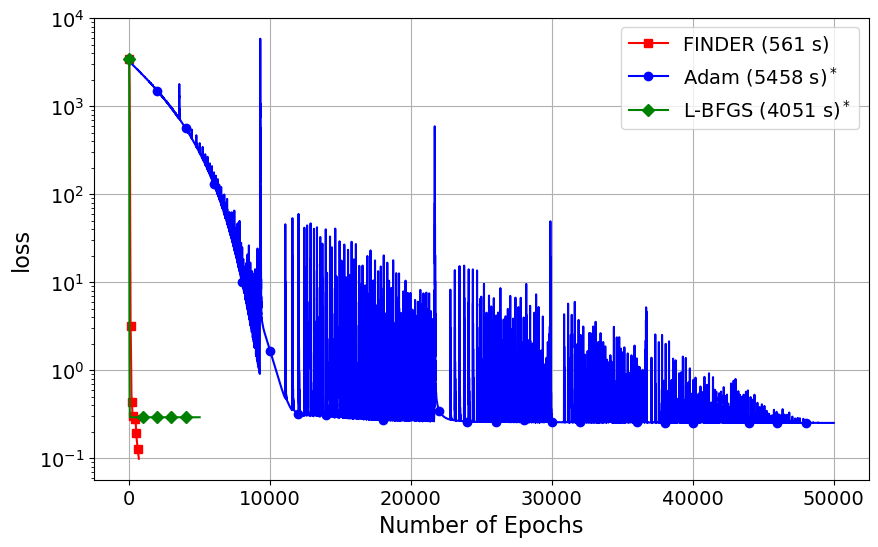

In [37]:
# Set figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # width, height
ax = plt.axes()


plt.plot(fx, 'rs-', markevery= 100, label=f"FINDER ({runtime_FINDER} s)")
plt.plot(fx_adam, 'bo-', markevery= 2000, label=f"Adam ({runtime_adam} s)$^*$")
plt.plot(fx_LBFGS, 'gD-', markevery= 1000, label=f"L-BFGS ({runtime_lbfgs} s)$^*$")

plt.ylabel('loss', fontsize=16)
plt.xlabel('Number of Epochs', fontsize=16)
plt.legend(loc="best", ncol=1, fontsize=14)
plt.yscale('log')
plt.grid()
plt.tick_params(axis='both', labelsize=14)
plt.show()

# testing

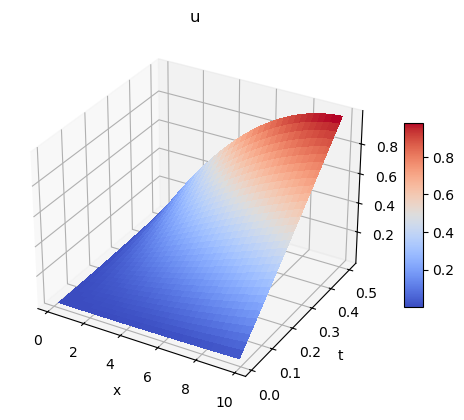

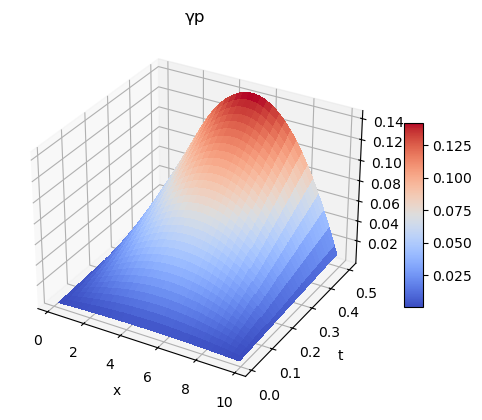

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

ngrid = 64
ts = torch.linspace(t0, t1, ngrid)
xs = torch.linspace(x0, x1, ngrid)
ts = ts[1:]
xs = xs[1:-1]
tgrid, xgrid = torch.meshgrid(ts, xs)
tgrid1 = tgrid.flatten().view(-1,1).to(device)
xgrid1 = xgrid.flatten().view(-1,1).to(device)
xgrid1.requires_grad_(True)
X = torch.cat([tgrid1, xgrid1], dim=1).to(device)

u = tgrid1 * xgrid1 * (1-xgrid1) * model.u(X) + tgrid1 * xgrid1 * umax/U
γp = tgrid1 * xgrid1 * (1-xgrid1) * model.γp(X)
u *= U
γp *= Γ

u = u.detach().cpu().numpy()
γp = γp.detach().cpu().numpy()

names = ['u', 'γp']

for name,value in zip(names,[u, γp]):
    value = value.reshape(xgrid.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(xgrid * L, tgrid * T, value, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    plt.title(name)
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()

# save data

In [38]:
torch.save(torch.tensor(fx), f'../PlotData/plasticity/plasticity_FINDER_N{model.start.shape[0]}_{runtime_FINDER}s.pt')

In [39]:
torch.save(torch.tensor(fx_adam), f'../PlotData/plasticity/plasticity_Adam_N{model.start.shape[0]}_{runtime_adam}s.pt')

In [40]:
torch.save(torch.tensor(fx_LBFGS), f'../PlotData/plasticity/plasticity_lbfgs_N{model.start.shape[0]}_{runtime_lbfgs}s.pt')